# Applied Machine Learning

## Imports

In [157]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [100]:
df = pd.read_csv('/Users/yangchenqi/Desktop/credit_card_customer_project/BankChurners.csv')
# Rename the column names
df.rename(columns={
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'NB_Prob_Active',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2': 'NB_Prob_Churned'
}, inplace=True)

df["Attrition_Flag"] = df["Attrition_Flag"].map({
    "Existing Customer": 0,
    "Attrited Customer": 1
})
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,NB_Prob_Active,NB_Prob_Churned
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


## Introduction


## Data Splitting

Split the data into train (80%) and test (20%) portions with `random_state = 123`.

In [101]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.shape

(7088, 23)

## Further EDA

Select evaluation metrics: Choose one or more appropriate metrics for assessing model performance and briefly justify your choice.

In [102]:
print(
    "Fraction that default:\n",
    train_df["Attrition_Flag"].value_counts(normalize=True),
)

Fraction that default:
 Attrition_Flag
0    0.836343
1    0.163657
Name: proportion, dtype: float64


We have a class imbalance. Both classes seem important here and I am going to pick macro-average f1 score as our evaluation metric

In [103]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer

In [104]:
X_train, y_train = (
    train_df.drop(columns=["Attrition_Flag"]),
    train_df["Attrition_Flag"],
)
X_test, y_test = (
    test_df.drop(columns=["Attrition_Flag"]),
    test_df["Attrition_Flag"],
)

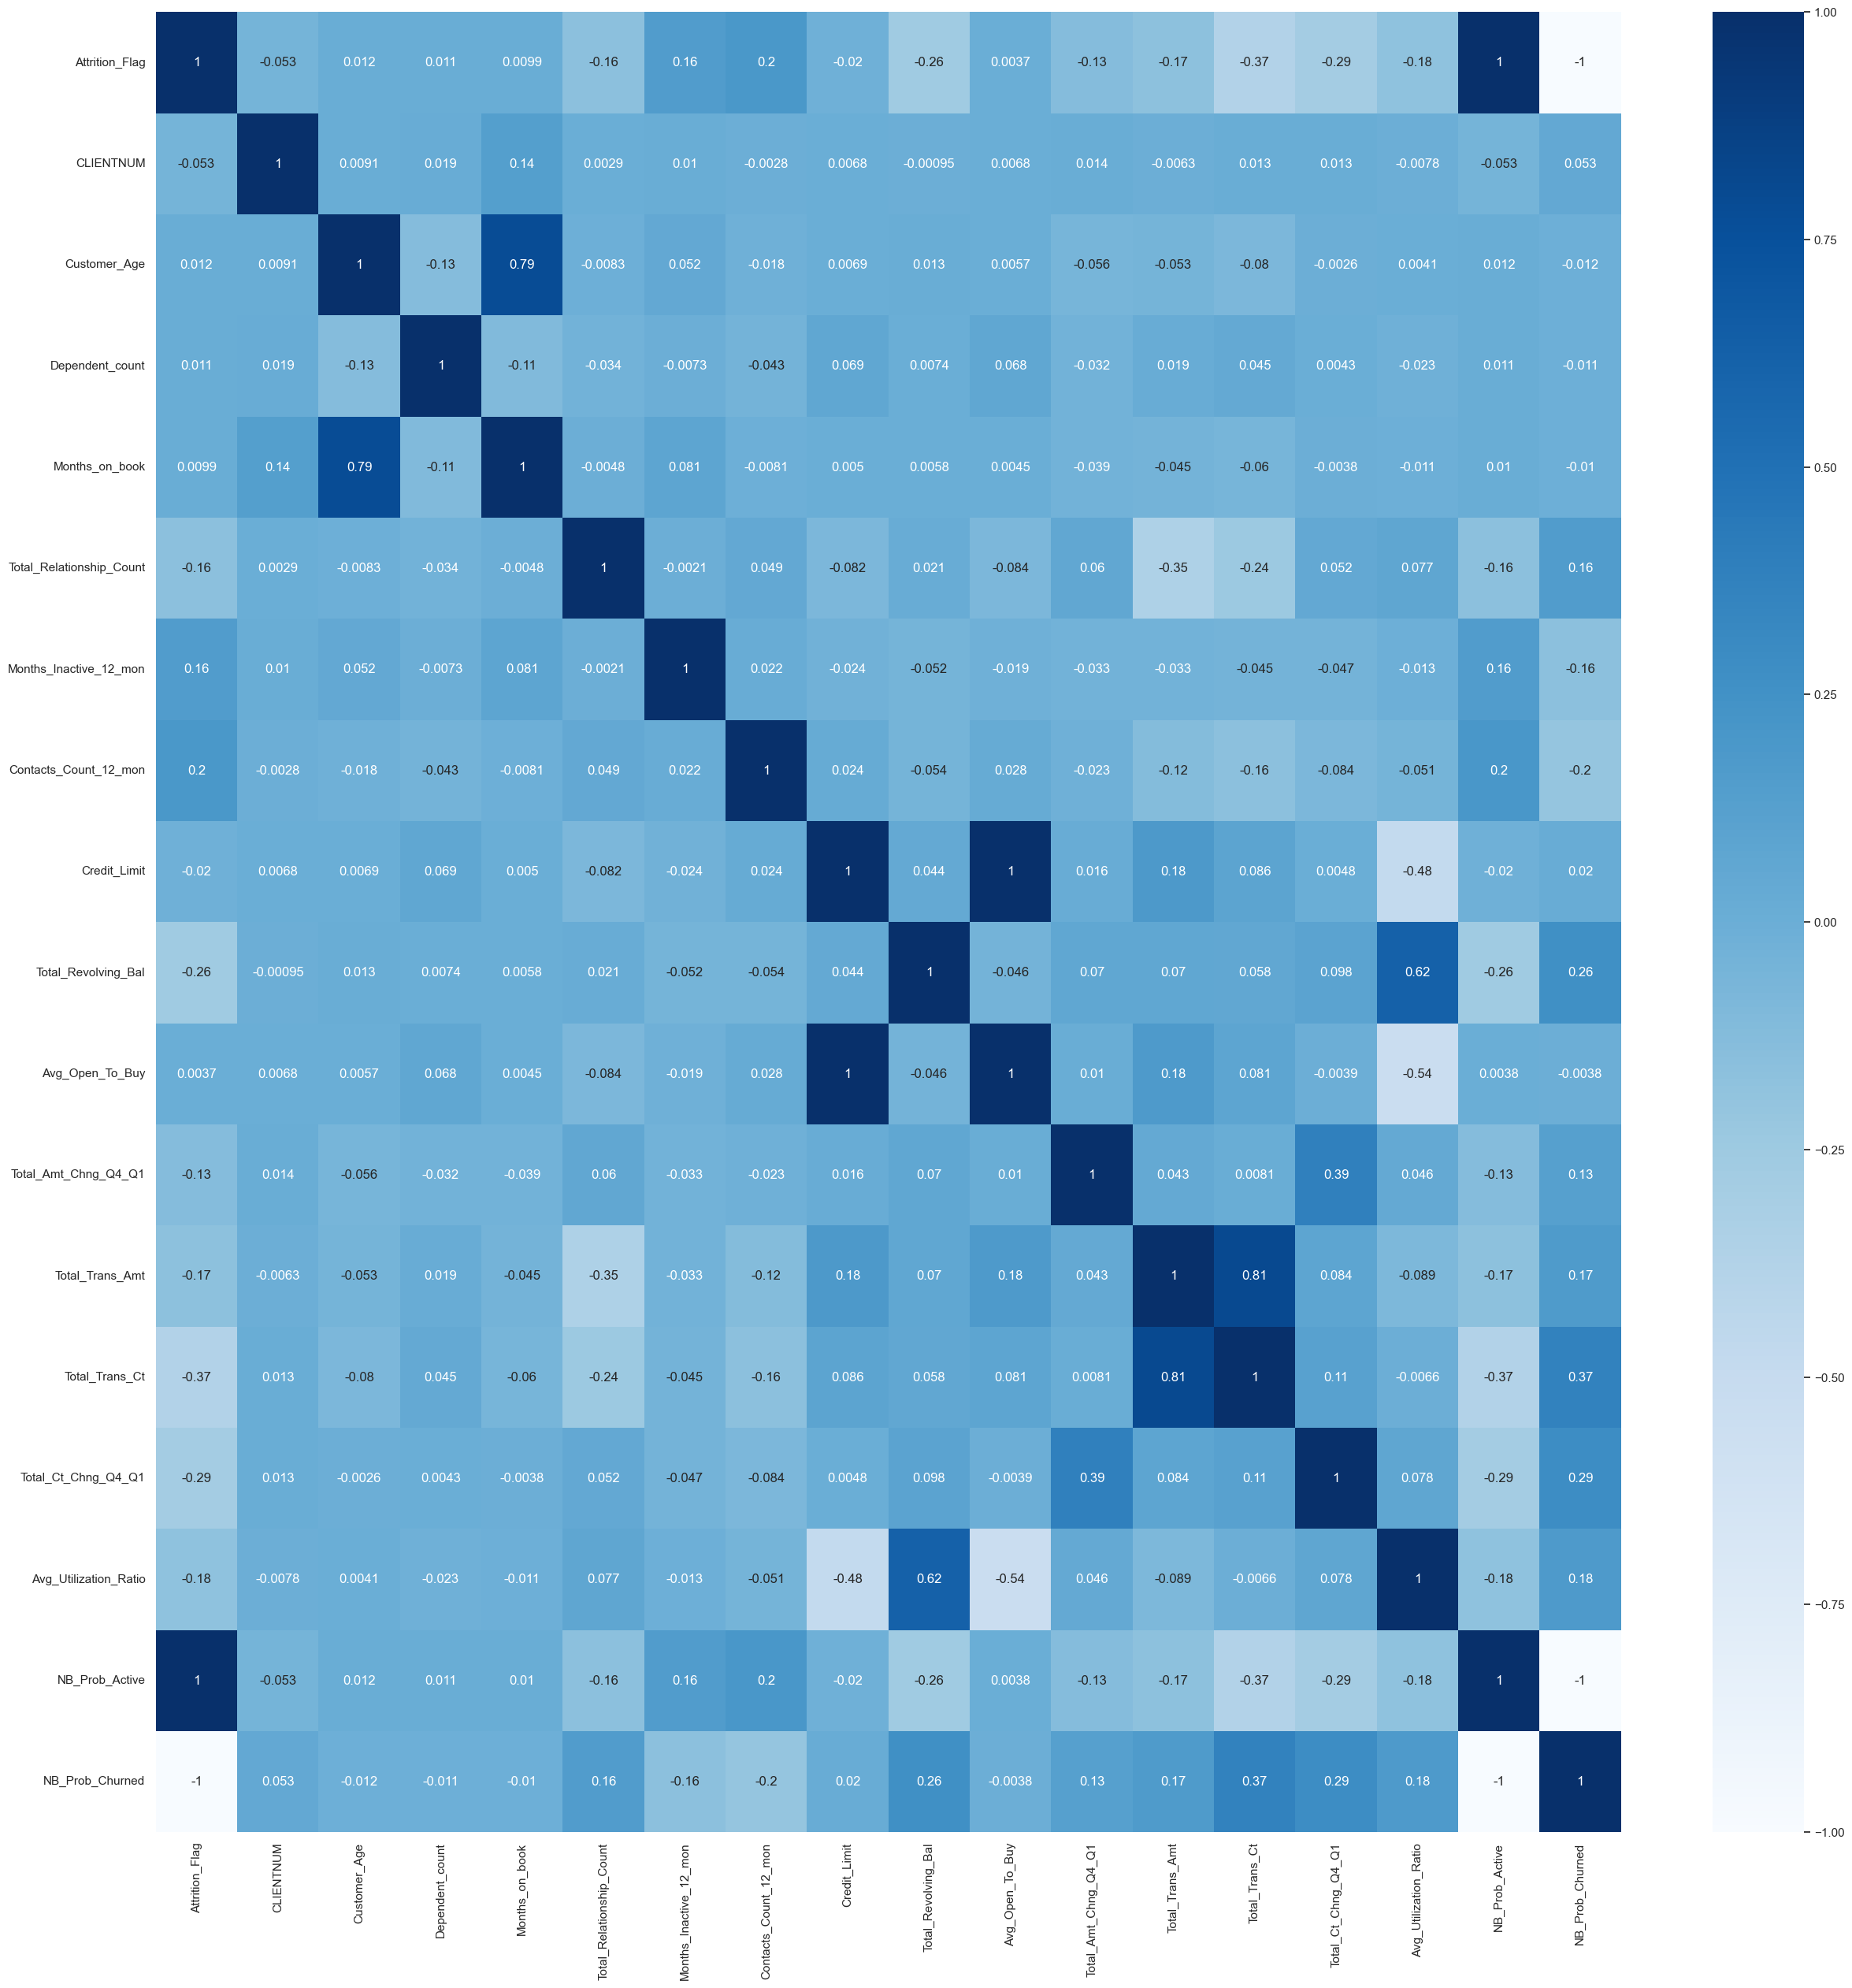

In [105]:
import seaborn as sns
cor = pd.concat((y_train, X_train), axis=1).iloc[:, :30].corr(numeric_only=True)
plt.figure(figsize=(30, 30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

Some initial observations:

- We have very few features.
- We have class imbalance and we need to deal with it. We have chosen macro average f1 as our target metric so that both classes get equal weight.
- The feature ranges are very different, so we'll need to standardize.
- We have a number of collinear features.
- We have quite a few outliers.
- The data is messy / doesn't always correspond to the data description.
   - What are education levels 5 and 6?
   - What does it mean for PAY_* to be -2? Or 0?

## Preprocessing and Transformations
Identify feature types: Determine the different types of features in your dataset (e.g., numerical, categorical, ordinal, text) and specify the transformations you would apply to each type.

Define a column transformer (if needed): Implement a ColumnTransformer to apply the appropriate preprocessing steps to each feature type.

In [106]:
drop_features = ["CLIENTNUM", "NB_Prob_Active", "NB_Prob_Churned"]
numeric_features = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Avg_Open_To_Buy",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio"
]
binary_features = ["Gender"]
categorical_features = ["Education_Level", 
                        "Marital_Status",
                        "Income_Category",
                        "Card_Category", 
]
target = "Attrition_Flag"

In [107]:
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
)

In [108]:
preprocessor.fit(X_train)
# feature_names = preprocessor.get_feature_names_out()
# feature_names = (
#      numeric_features
#      + binary_features   
#      + preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist()
#  )

In [109]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}

## Baseline model
Establish a baseline: Use one of scikit-learn’s baseline models (e.g., DummyClassifier or DummyRegressor, depending on your task) and report the results. This will serve as a reference point for evaluating the performance of your more advanced models.

In [110]:
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

In [111]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy
fit_time,0.009 (+/- 0.014)
score_time,0.010 (+/- 0.013)
test_score,0.493 (+/- 0.008)
train_score,0.501 (+/- 0.007)


In [112]:
cross_val_score(dummy, X_train, y_train)

array([0.72073343, 0.7157969 , 0.72425952, 0.72053634, 0.71771348])

## Linear Models
Train a linear model: Use a linear model as your first real attempt at solving the problem.

Tune hyperparameters: Perform hyperparameter tuning to explore different values of the model's complexity parameter.

Evaluate with cross-validation: Report the cross-validation scores along with their standard deviation.

Summarize findings: Summarize your results, highlighting key observations from your experiments.

In [113]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced")
)
results["logreg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy,logreg
fit_time,0.009 (+/- 0.014),0.059 (+/- 0.011)
score_time,0.010 (+/- 0.013),0.019 (+/- 0.006)
test_score,0.493 (+/- 0.008),0.770 (+/- 0.004)
train_score,0.501 (+/- 0.007),0.774 (+/- 0.003)


In [114]:
from scipy.stats import lognorm, loguniform, randint

param_grid = {"logisticregression__C": loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=1000))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.",{'logisticregression__C': <scipy.stats....t 0x1331738d0>}
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None ch

In [115]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]


Best hyperparameter values:  {'logisticregression__C': np.float64(0.03182234592129467)}
Best score: 0.772


,mean_train_score,mean_test_score,param_logisticregression__C,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.772754,0.772075,0.031822,0.136694,0.005029
2,0.772694,0.771331,0.022967,0.094530,0.005364
3,0.772507,0.771215,0.074742,0.060099,0.004923
4,0.772473,0.771184,0.023420,0.053969,0.005635
5,0.773453,0.770946,0.057847,0.056783,0.004824
6,0.772276,0.770940,0.080115,0.082046,0.004641
7,0.772149,0.770665,0.086647,0.057117,0.004461
8,0.772958,0.770528,0.052100,0.061700,0.004908
9,0.772209,0.770232,0.114569,0.079346,0.003861


In [116]:
best_logreg = random_search.best_estimator_
results["logreg (tuned)"] = mean_std_cross_val_scores(
    best_logreg, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.009 (+/- 0.014),0.010 (+/- 0.013),0.493 (+/- 0.008),0.501 (+/- 0.007)
logreg,0.059 (+/- 0.011),0.019 (+/- 0.006),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.221 (+/- 0.161),0.045 (+/- 0.022),0.772 (+/- 0.006),0.773 (+/- 0.003)


- Logistic regression scores are better than the dummy classifier scores.
- Optimizing the regularization hyperparameter of logistic regression improved the validation scores slightly (from 0.625 to 0.629) but not by much.
- In both cases it seems like we are underfitting; there is not much gap between train and validation scores. Probably non-linear models might be a better choice here.

## Different Models
Experiment with additional models: Train at least three models other than a linear model. Ensure that at least one of these models is a tree-based ensemble model (e.g., Random Forest, Gradient Boosting, or XGBoost).

Compare and interpret results: Summarize your findings in terms of overfitting/underfitting behavior and fit/score times for each model. Reflect on your results. Were you able to outperform the linear model?

In [117]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
ratio

np.float64(5.110344827586207)

In [118]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "RBF SVM": SVC(),
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=2),
    "xgboost": XGBClassifier(scale_pos_weight=ratio, random_state=2),
    "lgbm": LGBMClassifier(scale_pos_weight=ratio, random_state=2, verbose=-1),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X d

,fit_time,score_time,test_score,train_score
dummy,0.009 (+/- 0.014),0.010 (+/- 0.013),0.493 (+/- 0.008),0.501 (+/- 0.007)
logreg,0.059 (+/- 0.011),0.019 (+/- 0.006),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.221 (+/- 0.161),0.045 (+/- 0.022),0.772 (+/- 0.006),0.773 (+/- 0.003)
RBF SVM,0.909 (+/- 0.463),0.772 (+/- 0.417),0.866 (+/- 0.006),0.907 (+/- 0.002)
random forest,1.089 (+/- 0.033),0.045 (+/- 0.008),0.896 (+/- 0.009),1.000 (+/- 0.000)
xgboost,0.269 (+/- 0.009),0.020 (+/- 0.000),0.942 (+/- 0.005),1.000 (+/- 0.000)
lgbm,0.278 (+/- 0.042),0.031 (+/- 0.004),0.941 (+/- 0.007),0.999 (+/- 0.000)


I am using four non-linear models here: RBF SVM and three tree-based models.

We are trying all models with default hyperparameters.

Similar to logistic regression, SVC also seems to underfit; the gap between train and test scores are not large. Also, as expected, it takes longer to fit compared to other models. Let's abandon it.

LGBM seems to be the best performing model among the tree-based models. It also seems to be much faster and overfitting less compared to random forest and xgboost. That said, it's std is higher than the other two models.

## Feature Selection
Perform feature selection: Attempt to select relevant features using methods such as RFECV or forward selection.

Evaluate the impact Compare the model performance before and after feature selection. Do the results improve with feature selection?

Summarize findings Summarize your observations and decide whether to keep feature selection in your pipeline. If it improves results, retain it for the next exercises; otherwise, you may choose to omit it.

In [122]:
from sklearn.feature_selection import RFE, RFECV, SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(
                solver="saga",
                l1_ratio=1.0,
                C=1.0,
                max_iter=5000,
                random_state=123
            )
        ),
        model,
    )
    results[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X d

In [123]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.009 (+/- 0.014),0.010 (+/- 0.013),0.493 (+/- 0.008),0.501 (+/- 0.007)
logreg,0.059 (+/- 0.011),0.019 (+/- 0.006),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.221 (+/- 0.161),0.045 (+/- 0.022),0.772 (+/- 0.006),0.773 (+/- 0.003)
RBF SVM,0.909 (+/- 0.463),0.772 (+/- 0.417),0.866 (+/- 0.006),0.907 (+/- 0.002)
random forest,1.089 (+/- 0.033),0.045 (+/- 0.008),0.896 (+/- 0.009),1.000 (+/- 0.000)
xgboost,0.269 (+/- 0.009),0.020 (+/- 0.000),0.942 (+/- 0.005),1.000 (+/- 0.000)
lgbm,0.278 (+/- 0.042),0.031 (+/- 0.004),0.941 (+/- 0.007),0.999 (+/- 0.000)
RBF SVM+ feat_sel,2.462 (+/- 1.167),0.335 (+/- 0.067),0.872 (+/- 0.006),0.906 (+/- 0.002)
random forest+ feat_sel,2.517 (+/- 0.947),0.038 (+/- 0.003),0.898 (+/- 0.008),1.000 (+/- 0.000)
xgboost+ feat_sel,1.867 (+/- 0.869),0.020 (+/- 0.001),0.945 (+/- 0.005),1.000 (+/- 0.000)


In [125]:
pipe_random_forest = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(
                solver="saga",
                l1_ratio=1.0,
                C=1.0,
                max_iter=5000,
                random_state=123
            )
    ),
    models["random forest"],
)

pipe_random_forest.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_random_forest.named_steps["randomforestclassifier"].n_features_in_,
)

Number of features selected:  30


## Hyperparameter Optimization
Optimize hyperparameters: Attempt to optimize hyperparameters for the models you have tried so far. In at least one case, tune multiple hyperparameters for a single model.

Use suitable optimization methods: You may use any of the following approaches for hyperparameter optimization:

GridSearchCV
RandomizedSearchCV
Bayesian optimization with scikit-optimize
Summarize your results: Report and compare the optimized results across models. Discuss whether hyperparameter optimization led to performance improvements.

In [126]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
}

pipe_random_forest = make_pipeline(preprocessor, models["random forest"])

In [127]:
random_search_rf = RandomizedSearchCV(
    pipe_random_forest,
    param_grid_rf,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...om_state=2))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'randomforestclassifier__max_depth': <scipy.stats....t 0x1340a88d0>, 'randomforestclassifier__n_estimators': <scipy.stats....t 0x1331efed0>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation str

In [128]:
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 79}
Best score: 0.905


,mean_train_score,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.992598,0.904753,79,12,0.907971,0.004133
2,0.975382,0.904659,35,10,0.346826,0.006702
3,0.964578,0.904552,76,9,0.682378,0.004293
4,0.986371,0.904116,62,11,0.582052,0.007387
5,0.991845,0.903456,67,12,1.056300,0.003488
6,0.986055,0.903160,42,11,0.498100,0.009404
7,0.998073,0.902723,58,14,0.605930,0.006469
8,0.991012,0.902487,32,12,0.332480,0.008177
9,0.950922,0.901905,95,8,0.777210,0.007356


In [129]:
best_rf_model = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.009 (+/- 0.014),0.010 (+/- 0.013),0.493 (+/- 0.008),0.501 (+/- 0.007)
logreg,0.059 (+/- 0.011),0.019 (+/- 0.006),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.221 (+/- 0.161),0.045 (+/- 0.022),0.772 (+/- 0.006),0.773 (+/- 0.003)
RBF SVM,0.909 (+/- 0.463),0.772 (+/- 0.417),0.866 (+/- 0.006),0.907 (+/- 0.002)
random forest,1.089 (+/- 0.033),0.045 (+/- 0.008),0.896 (+/- 0.009),1.000 (+/- 0.000)
xgboost,0.269 (+/- 0.009),0.020 (+/- 0.000),0.942 (+/- 0.005),1.000 (+/- 0.000)
lgbm,0.278 (+/- 0.042),0.031 (+/- 0.004),0.941 (+/- 0.007),0.999 (+/- 0.000)
RBF SVM+ feat_sel,2.462 (+/- 1.167),0.335 (+/- 0.067),0.872 (+/- 0.006),0.906 (+/- 0.002)
random forest+ feat_sel,2.517 (+/- 0.947),0.038 (+/- 0.003),0.898 (+/- 0.008),1.000 (+/- 0.000)
xgboost+ feat_sel,1.867 (+/- 0.869),0.020 (+/- 0.001),0.945 (+/- 0.005),1.000 (+/- 0.000)


#### LGBM Hyperparameter optimization

In [130]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    # "lgbmclassifier__max_depth": randint(low=2, high=20),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

pipe_lgbm = make_pipeline(
    preprocessor,
    models["lgbm"],
)

In [131]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X d

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...verbose=-1))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'lgbmclassifier__learning_rate': [0.01, 0.1], 'lgbmclassifier__n_estimators': <scipy.stats....t 0x135eebd10>, 'lgbmclassifier__subsample': [0.5, 0.75, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscros

In [133]:
print("Best hyperparameter values: ", random_search_lgbm.best_params_)
print("Best score: %0.3f" % (random_search_lgbm.best_score_))

pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__learning_rate",
        "param_lgbmclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__n_estimators': 93, 'lgbmclassifier__subsample': 0.5}
Best score: 0.943


,mean_train_score,mean_test_score,param_lgbmclassifier__n_estimators,param_lgbmclassifier__learning_rate,param_lgbmclassifier__subsample,mean_fit_time
rank_test_score,,,,,,
1,0.997625,0.942847,93,0.1,0.50,0.242175
2,0.998009,0.942614,95,0.1,1.00,0.221280
3,0.996347,0.942218,86,0.1,0.50,0.214478
4,0.998073,0.942090,96,0.1,1.00,0.889682
5,0.996092,0.942071,85,0.1,1.00,0.330289
6,0.994946,0.941952,80,0.1,0.50,0.239017
7,0.994248,0.941811,77,0.1,0.75,0.286609
7,0.994248,0.941811,77,0.1,1.00,0.376443
9,0.994566,0.941723,79,0.1,0.50,0.187140


In [134]:
best_lgbm_model = random_search_lgbm.best_estimator_
results["lgbm (tuned)"] = mean_std_cross_val_scores(
    best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X d

,fit_time,score_time,test_score,train_score
dummy,0.009 (+/- 0.014),0.010 (+/- 0.013),0.493 (+/- 0.008),0.501 (+/- 0.007)
logreg,0.059 (+/- 0.011),0.019 (+/- 0.006),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.221 (+/- 0.161),0.045 (+/- 0.022),0.772 (+/- 0.006),0.773 (+/- 0.003)
RBF SVM,0.909 (+/- 0.463),0.772 (+/- 0.417),0.866 (+/- 0.006),0.907 (+/- 0.002)
random forest,1.089 (+/- 0.033),0.045 (+/- 0.008),0.896 (+/- 0.009),1.000 (+/- 0.000)
xgboost,0.269 (+/- 0.009),0.020 (+/- 0.000),0.942 (+/- 0.005),1.000 (+/- 0.000)
lgbm,0.278 (+/- 0.042),0.031 (+/- 0.004),0.941 (+/- 0.007),0.999 (+/- 0.000)
RBF SVM+ feat_sel,2.462 (+/- 1.167),0.335 (+/- 0.067),0.872 (+/- 0.006),0.906 (+/- 0.002)
random forest+ feat_sel,2.517 (+/- 0.947),0.038 (+/- 0.003),0.898 (+/- 0.008),1.000 (+/- 0.000)
xgboost+ feat_sel,1.867 (+/- 0.869),0.020 (+/- 0.001),0.945 (+/- 0.005),1.000 (+/- 0.000)


Summary of observations

Hyperparameter optimization seems to help with random forests as well as LightGBM. The scores for both models seem very similar. But we pick LightGBM because

it seems to be less overfitting
it's much faster
the standard deviation is smaller compared to random forest.

## Interpretation and feature importances
Your tasks:

Interpret model feature importance: Use one of the interpretation methods discussed in class (e.g., shap), or another suitable method of your choice, to examine the most important features of one of your non-linear models.

Summarize insights: Summarize your observations about which features contribute most to the model's predictions and how they influence the outcomes.

In [136]:
import shap

preprocessor.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
4503,0.326774,1.275550,0.502311,0.774032,-1.326404,-1.317528,-0.053443,0.673539,-0.113737,0.275464,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
365,-0.421142,1.275550,0.376980,-0.508272,0.656000,0.489834,0.687221,-0.380323,0.721195,0.013868,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1887,-0.171837,-0.270333,0.251650,0.132880,3.629605,1.393515,0.877927,-1.424336,1.005347,0.895035,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5458,0.326774,1.275550,0.126320,-1.790577,-0.335202,-0.413847,0.170664,1.516875,0.034842,-1.523585,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
85,0.700732,-0.270333,1.379621,0.774032,0.656000,-2.221209,-0.613102,0.927155,-0.696040,0.743584,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [137]:
lgbm_tuned = LGBMClassifier(
    scale_pos_weight=ratio,
    random_state=2,
    learning_rate=random_search_lgbm.best_params_["lgbmclassifier__learning_rate"],
    n_estimators=random_search_lgbm.best_params_["lgbmclassifier__n_estimators"],
    subsample=random_search_lgbm.best_params_["lgbmclassifier__subsample"],
)

lgbm_tuned.fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(lgbm_tuned)
lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [138]:
values = np.abs(lgbm_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
Customer_Age,0.133747
Dependent_count,0.133747
Months_on_book,0.133747
Total_Relationship_Count,0.133747
Months_Inactive_12_mon,0.133747
Contacts_Count_12_mon,0.133747
Credit_Limit,0.133747
Total_Revolving_Bal,0.133747
Avg_Open_To_Buy,0.133747
Total_Amt_Chng_Q4_Q1,0.133747


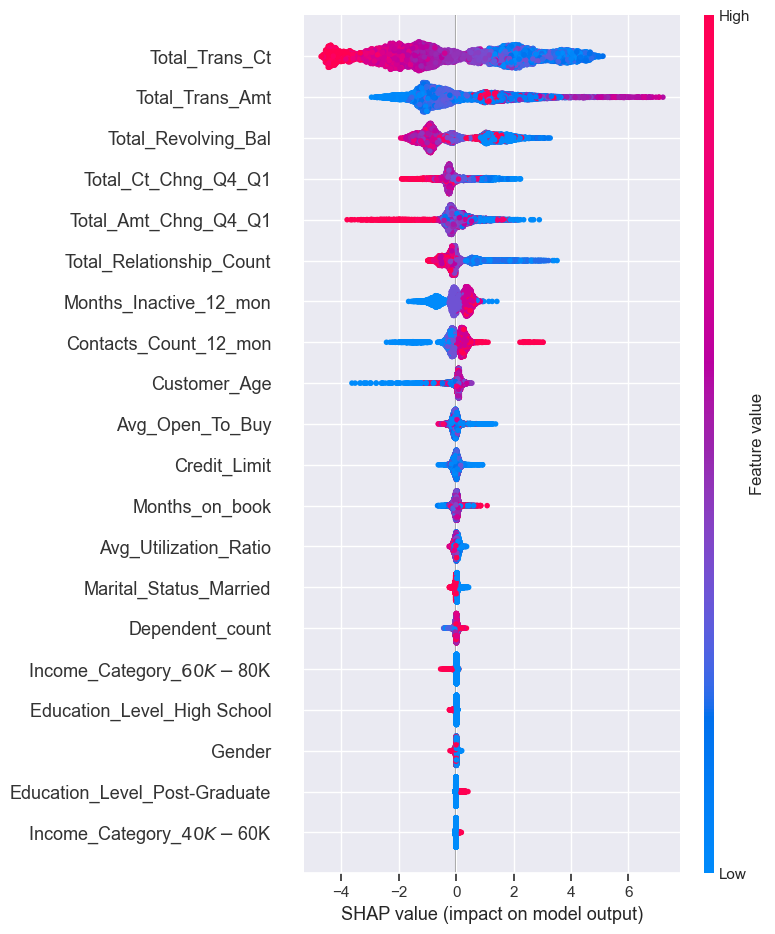

In [141]:
shap.summary_plot(lgbm_shap_values, X_train_enc)

In [146]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [147]:
lgbm_tuned.predict_proba(X_test_enc)[1]

array([0.99615543, 0.00384457])

In [148]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[1]

np.float64(-5.557240612865709)

## Results on the test set
Evaluate on the test set: Apply your best-performing model to the test data and report the test scores.

Compare and reflect: Compare the test scores with the validation scores from previous experiments. Discuss the consistency between them. How much do you trust your results? Reflect on whether you might have encountered optimization bias.

Explain individual predictions: Select one or two examples from your test predictions and use an interpretation method (e.g., SHAP force plots) to explain these individual predictions.

In [142]:
from sklearn.metrics import f1_score

best_model = random_search_lgbm.best_estimator_
print(
    "Grid Search best model validation score: %0.3f" % (random_search_lgbm.best_score_)
)

predictions = best_model.predict(X_test)
print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, predictions, average="macro"))
)

Grid Search best model validation score: 0.943
Macro-average f1 score on the test set: 0.940


/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


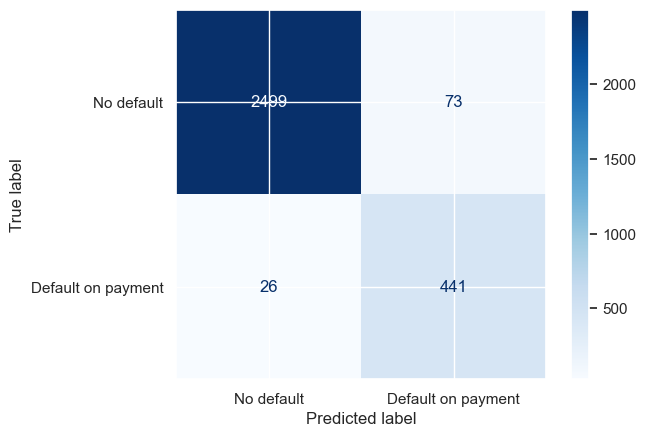

In [143]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=["No default", "Default on payment"],
    values_format="d",
    cmap=plt.cm.Blues,
)

In [144]:
print(
    classification_report(
        y_test, predictions, target_names=["No default", "Default on payment"]
    )
)

                    precision    recall  f1-score   support

        No default       0.99      0.97      0.98      2572
Default on payment       0.86      0.94      0.90       467

          accuracy                           0.97      3039
         macro avg       0.92      0.96      0.94      3039
      weighted avg       0.97      0.97      0.97      3039



#### Explanation of a non-default prediction

In [150]:
y_test_reset = y_test.reset_index(drop=True)
non_default_ind = y_test_reset[y_test_reset == 0].index.tolist()
default_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_non_default_index = non_default_ind[0]
ex_default_index = default_ind[0]

In [151]:
lgbm_tuned.predict_proba(X_test_enc)[ex_non_default_index]

array([0.99856162, 0.00143838])

#### Explanation of a default prediction

In [152]:
lgbm_tuned.predict_proba(X_test_enc)[ex_default_index]

array([0.00400559, 0.99599441])

In [153]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[ex_default_index]


np.float64(5.516050864833963)

## Summary of results
Summarize key results: Create a clear and concise table highlighting your most important results (e.g., models compared, validation/test scores, key observations).

Write concluding remarks: Summarize your main takeaways from the project, including what worked well and what did not.

Propose future improvements: Discuss ideas or approaches you did not try but that could potentially improve performance or interpretability.

Report final results: Report your final test score and the metric you used.

In [154]:
pd.DataFrame(results).T
summary_df = pd.DataFrame(results).T

In [156]:
comments = {
    "dummy": "Baseline of 0.50 macro-average f1 score.",
    "logreg": "Improvement over the baseline but underfitting.",
    "logreg (tuned)": "Slight improvement but still underfitting.",
    "RBF SVM": "Improvement over tuned logistic regression but slow.",
    "random forest": "Improvement over tuned logistic regression but overfitting.",
    "xgboost": "Best results so far and less overfitting compared to random forest.",
    "lgbm": "Improvement over xgboost and less overfitting.",
    "random forest+ feat_sel": "Feature selection with L1 regularization helps a tiny bit. Selects 29 features.",
    "xgboost+ feat_sel": "Very tiny improvement with L1 feature selection.",
    "lgbm+ feat_sel": "No improvemnt with L1 feature selection.",
    "random forest (tuned)": "Hyperparameter optimization helped! Best results so far.",
    "lgbm (tuned)": "Hyperparameter optimization helped. Best results overall! The scores are very similar to random forest scores but picking this as the best model for its speed.",
}
pd.set_option("display.max_colwidth", 0)
summary_df["comments"] = summary_df.index.map(comments)
summary_df

,fit_time,score_time,test_score,train_score,comments
dummy,0.009 (+/- 0.014),0.010 (+/- 0.013),0.493 (+/- 0.008),0.501 (+/- 0.007),Baseline of 0.50 macro-average f1 score.
logreg,0.059 (+/- 0.011),0.019 (+/- 0.006),0.770 (+/- 0.004),0.774 (+/- 0.003),Improvement over the baseline but underfitting.
logreg (tuned),0.221 (+/- 0.161),0.045 (+/- 0.022),0.772 (+/- 0.006),0.773 (+/- 0.003),Slight improvement but still underfitting.
RBF SVM,0.909 (+/- 0.463),0.772 (+/- 0.417),0.866 (+/- 0.006),0.907 (+/- 0.002),Improvement over tuned logistic regression but slow.
random forest,1.089 (+/- 0.033),0.045 (+/- 0.008),0.896 (+/- 0.009),1.000 (+/- 0.000),Improvement over tuned logistic regression but overfitting.
xgboost,0.269 (+/- 0.009),0.020 (+/- 0.000),0.942 (+/- 0.005),1.000 (+/- 0.000),Best results so far and less overfitting compared to random forest.
lgbm,0.278 (+/- 0.042),0.031 (+/- 0.004),0.941 (+/- 0.007),0.999 (+/- 0.000),Improvement over xgboost and less overfitting.
RBF SVM+ feat_sel,2.462 (+/- 1.167),0.335 (+/- 0.067),0.872 (+/- 0.006),0.906 (+/- 0.002),NaN
random forest+ feat_sel,2.517 (+/- 0.947),0.038 (+/- 0.003),0.898 (+/- 0.008),1.000 (+/- 0.000),Feature selection with L1 regularization helps a tiny bit. Selects 29 features.
xgboost+ feat_sel,1.867 (+/- 0.869),0.020 (+/- 0.001),0.945 (+/- 0.005),1.000 (+/- 0.000),Very tiny improvement with L1 feature selection.
